# Tecniche di Gradient Descent

### Obiettivi:

Fare pratica con l'uso della tecnica di discesa lungo il gradiente e delle tecniche associate (momentum, ADAM, RMSProp, ...) per lo studio dei minimi di funzioni bidimensionali.

**Prima parte: visualizzazione grafica delle funzioni**

In [0]:
# setup delle funzioni di visualizzazione di base usate successivamente

# configura matplotlib in modo che l'output sia in linea con il codice della cella del notebook che lo ha
# prodotto e sia salvato con il notebook stesso
%matplotlib inline

# importa le librerie necessarie
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# 3D plots
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LogNorm
from collections import OrderedDict as OrD

# funzioni per plottare
def plot_surface(x, y, z,
    azim=-60, elev=40, dist=10, cmap="RdYlBu_r",
    xlimL=1, xlimH=1, ylimL=1, ylimH=1, zlimL=2, zlimH=2,):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    plot_args = {
        "rstride": 1,
        "cstride": 1,
        "cmap": cmap,
        "linewidth": 20,
        "antialiased": True,
        "vmin": -2,
        "vmax": 2,
    }
    ax.plot_surface(x, y, z, **plot_args)
    ax.view_init(azim=azim, elev=elev)
    ax.dist = dist
    ax.set_xlim(-xlimL, xlimH)
    ax.set_ylim(-ylimL, ylimH)
    ax.set_zlim(-zlimL, zlimH)

    plt.xticks([-1, -0.5, 0, 0.5, 1], ["-1", "-1/2", "0", "1/2", "1"])
    plt.yticks([-1, -0.5, 0, 0.5, 1], ["-1", "-1/2", "0", "1/2", "1"])
    ax.set_zticks([-2, -1, 0, 1, 2])
    ax.set_zticklabels(["-2", "-1", "0", "1", "2"])

    ax.set_xlabel("x", fontsize=18)
    ax.set_ylabel("y", fontsize=18)
    ax.set_zlabel("z", fontsize=18)

    return fig, ax

def overlay_trajectory_contour_M(ax, trajectory, label, color="k", lw=2):
    xs, ys = trajectory[:, 0], trajectory[:, 1]
    ax.plot(xs, ys, color, label=label, lw=lw)
    ax.plot(xs[-1], ys[-1], color + ">", markersize=14)
    return ax


def overlay_trajectory_contour(ax, trajectory, label, color="k", lw=2):
    xs, ys = trajectory[:, 0], trajectory[:, 1]
    ax.plot(xs, ys, color, label=label, lw=lw)
    return ax

**Funzioni da studiare**

* funzione con minimo quadratico: $$z=ax^2+by^2,$$

* fuzione con un punto di sella: $$z=ax^2-by^2,$$

* funzione convessa di Beale: $$z = (1.5-x+xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2$$ con minimo in $$(\hat{x},\hat{y})=(3,0.5)$$

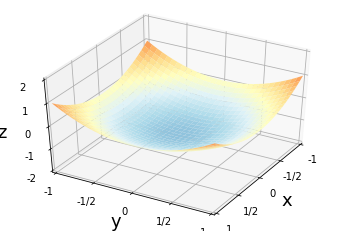

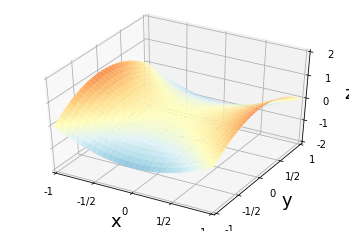

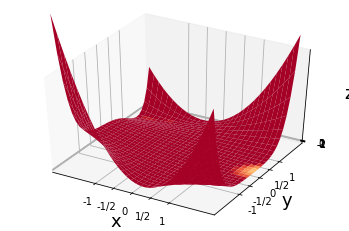

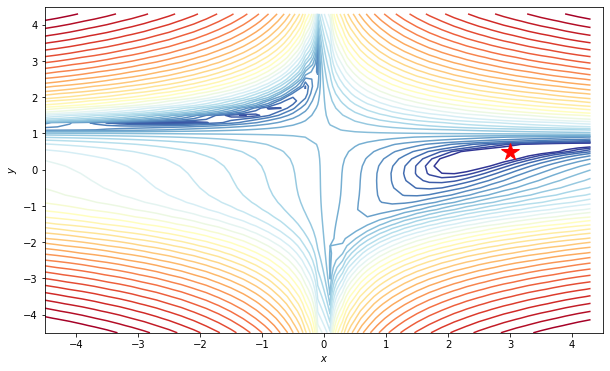

In [0]:
# funzione con minimo quadratico
def minima_surface(x, y, a=1, b=1):
    return a * x ** 2 + b * y ** 2 - 1


# gradiente analitico
def grad_minima_surface(params, a=1, b=1):
    x = params[0]
    y = params[1]
    grad_x = 2 * a * x
    grad_y = 2 * b * y
    return [grad_x, grad_y]


# funzione con punto di sella
def saddle_surface(x, y, a=1, b=1):
    return a * x ** 2 - b * y ** 2

# funzione di Beale
def beales_function(x, y):
    z = (
        np.square(1.5 - x + x * y)
        + np.square(2.25 - x + x * y * y)
        + np.square(2.625 - x + x * y ** 3)
    )
    return z


# gradiente analitico
def grad_beales_function(params):
    x = params[0]
    y = params[1]
    grad_x = (
        2 * (1.5 - x + x * y) * (-1 + y)
        + 2 * (2.25 - x + x * y ** 2) * (-1 + y ** 2)
        + 2 * (2.625 - x + x * y ** 3) * (-1 + y ** 3)
    )
    grad_y = (
        2 * (1.5 - x + x * y) * x
        + 4 * (2.25 - x + x * y ** 2) * x * y
        + 6 * (2.625 - x + x * y ** 3) * x * y ** 2
    )
    return [grad_x, grad_y]

# contour plot della funzione di Beale
def contour_beales_function():
    # plot beales function
    x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
    fig, ax = plt.subplots(figsize=(10, 6))
    z = beales_function(x, y)
    cax = ax.contour(
        x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r"
    )
    ax.plot(3, 0.5, "r*", markersize=18)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_xlim((-4.5, 4.5))
    ax.set_ylim((-4.5, 4.5))
    return fig, ax

# plot delle superfici
plt.close()  # chiudi qualsiasi plot precedente
x, y = np.mgrid[-1:1:31j, -1:1:31j]
fig1, ax1 = plot_surface(x, y, minima_surface(x, y, 1), 30)
fig2, ax2 = plot_surface(x, y, saddle_surface(x, y))
x, y = np.mgrid[-2:2:31j, -2:2:31j]
fig3, ax3 = plot_surface(x, y, beales_function(x, y),
    xlimL=2.1, xlimH=2.1, ylimL=2.1, ylimH=2.1, zlimL=0, zlimH=300,)

# Contour plot della funzione di Bale
fig4, ax4 = contour_beales_function()
plt.show()

## Parte 2: discesa lungo il gradiente con e senza momentum

<b>simple Gradient Descent</b>

Implementazione di una semplice discesa lungo il gradiente, in cui dato un set di parametri $w$, qusti vengono aggiornati ad ogni iterazione nella direzione del gradiente locale:

$$w_{t+1}= w_t - \eta_t \nabla_w E(w),$$

in cui $E(w)$ rappresenta la funzione (energia nel linguaggio della fisica) che vogliamo minimizzare.

Il parametro $\eta_t$ (lerning rate) controlla la larghezza di ciascuno step. In generale l'algoritmo è estremamente sensibile al valore di $\eta_t$, se è troppo grande possono comparire grandi oscillazioni intorno al minimo (perdendo controllo sule strutture a piccola scala della funzione). Il problema diventa sempre più grande quanto più rumore è presente nelle stime de gradiente (come succede nel ML in cui il gradiente viene cacolato su campioni di eventi di dimensione limitata). Se $\eta_t$ è troppo piccola la porcedura di ottimizzazione diviene estremamente lenta.


<b>Gradient Descent + Momentum</b>

Aggiungere informazione su cosa è successo nelle iterazioni precedenti ("da dove proviene la palla che rotola giù dalla collina") aiuta ad evitare problemi con minimi locali sopratutto in presenza di rumore stocastico.
Questo può essere fatto aggiungendo un termine di memoria o momentum che permette sia di risucire ad uscire da minimi locali, sia di non reagire in modo esagerato ai cambiamenti presenti ad ogni nuova iterazione.
La regola di update diviene:

$$
v_{t}=\gamma v_{t-1}+\eta_{t}\nabla_w E(w_t),\\
w_{t+1}= w_t -v_{t},
$$

in cui $0\le \gamma < 1$ è un parametro detto momentum. Quando $\gamma=0$ si riottiene il GD ordinario, aumentando
$\gamma$ aumenta il contributo di inerzia al gardiente.

In [0]:
# implementazione funzioni GD e GD+momentum
# nota viene introdotta la possibilità di aggiungere una componente rumorosa al calcolo del gradiente per simulare
# l'effetto nell'uso del ML con campioni di dimensione finita

'''
Arguments:
  defined: Dict - contains the hyperparameters values needed
  default: Dict (if only one key) or OrderedDict - contains the default hyperparameters values
Returns a list of hyperparameters values as in 'defined',
with the same order of 'default'.
If an hyperparameter is not in 'defined', its value is taken from default.
'''
def get_par(defined, default):
    return [defined[key] if key in defined else default[key] for key in default]

# GD {}
def gd(grad, init, hyper_par, n_epochs=1000, noise_strength=0):
    default_par = {"eta": 0.1}
    eta = get_par(hyper_par, default_par)

    params = np.array(init)
    param_traj = np.zeros([n_epochs + 1, 2])
    param_traj[0,] = init
    v = 0
    for j in range(n_epochs):
        noise = noise_strength * np.random.randn(params.size)
        v = eta * (np.array(grad(params)) + noise)
        params = params - v
        param_traj[j + 1,] = params
    legend = "GD " + ", ".join(f"$\\{key}$={hyper_par[key]}" for key in hyper_par)
    return (param_traj, legend)


# GD + momentum
def gd_with_mom(grad, init, hyper_par, n_epochs=5000, noise_strength=0):
    default_par = OrD([("eta", 0.1), ("gamma", 0.9)])
    eta, gamma = get_par(hyper_par, default_par)

    params = np.array(init)
    param_traj = np.zeros([n_epochs + 1, 2])
    param_traj[0,] = init
    v = 0
    for j in range(n_epochs):
        noise = noise_strength * np.random.randn(params.size)
        v = gamma * v + eta * (np.array(grad(params)) + noise)
        params = params - v
        param_traj[j + 1,] = params
    legend = "GD+M " + ", ".join(f"$\\{key}$={hyper_par[key]}" for key in hyper_par)
    return (param_traj, legend)


'''
Arguments:
    ax: where to plot
    gradient: function returning the analitic gradient
    init: initial point
    hyper_par: dictionary of non-default hyperparameters (as above)
Returns trajectory
'''
def run_and_plot(ax, gradient, init, hyper_par,
                 marker='o', n_epochs=100, opt=gd, arrow=False, noise=0):
    param_traj, legend = opt(gradient, init, hyper_par, n_epochs=n_epochs, noise_strength=noise)
    if arrow:
        overlay_trajectory_contour_M(ax, param_traj, legend, marker, lw=0.5)
    else:
        overlay_trajectory_contour(ax, param_traj, legend, marker, lw=0.5)
    return param_traj

# Applicazione di GD e GD+Momentum

Applichiamo l'algoritmo alla funzione con minimo quadratico $z=ax^2+by^2-1$ con ($a=b=1$).

**Cose si vuole testare:**
* dipendenza dal learning rate: $\eta=0.1,0.5,1,1.01$;
* dipendenza dai parameri della funzione

**Da fare come esercizio:**
* cosa cambia modificando i parametri $a$ e $b$ della funzione? Superfici anisotrope presentano lo stesso comportamento?
* provare cosa cambia usando GD+Momentum. Come cambia la dipendenza da $\eta$ rispetto al caso senza momentum?

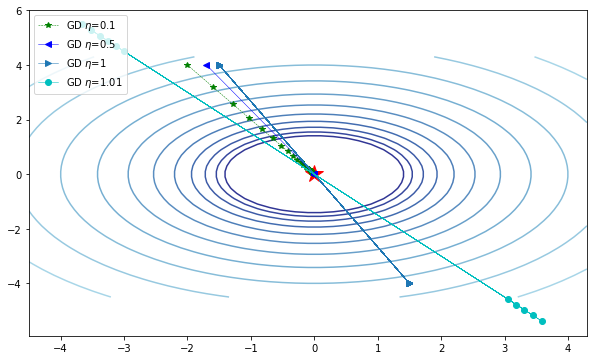

In [0]:
# studio effetto learning rate in GD
plt.close()
x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
fig, ax = plt.subplots(figsize=(10, 6))

a, b = 1.0, 1.0
z = np.abs(minima_surface(x, y, a, b))
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0, 0, 'r*', markersize=18)

#run_and_plot(ax, gradient, init, hyper_par, marker='o', n_epochs=100, opt=gd, arrow=False, noise=0):

run_and_plot(ax, grad_minima_surface, [-2,   4],   {'eta': 0.1}, 'g--*')
run_and_plot(ax, grad_minima_surface, [-1.7, 4],   {'eta': 0.5}, 'b-<')
run_and_plot(ax, grad_minima_surface, [-1.5, 4],   {'eta': 1}, '->')
run_and_plot(ax, grad_minima_surface, [-3,   4.5], {'eta': 1.01}, 'c-o', n_epochs=10)

plt.legend(loc=2)
plt.show()

### Svolgimento dell'esercizio
#### Osserviamo innanzitutto cosa accade modificando i parametri $a$ e $b$ senza .
Essendo la funzione asimmetrica compare un caso patologico, non presente in precedenza. <br>
Il gradiente è definito come $(2ax, 2by)$, per cui se scegliamo un punto di partenza $(x_0,y_0)$ tale che $(x_1,y_1) = (-x_0,y_1)$ allora non avremo convergenza su $x$, ma oscillazione. <br>
Scegliamo quindi $\eta=0.1$ (valore che in precedenza assicurava la convergenza), ma scegliamo $a = 10$, per cui: <br>
$x_1 = x_0 - 0.1 \cdot 2 \cdot 10 \cdot x_0 = - x_0$. <br>
Sull'asse $y$ si ha invece convergenza esponenziale.

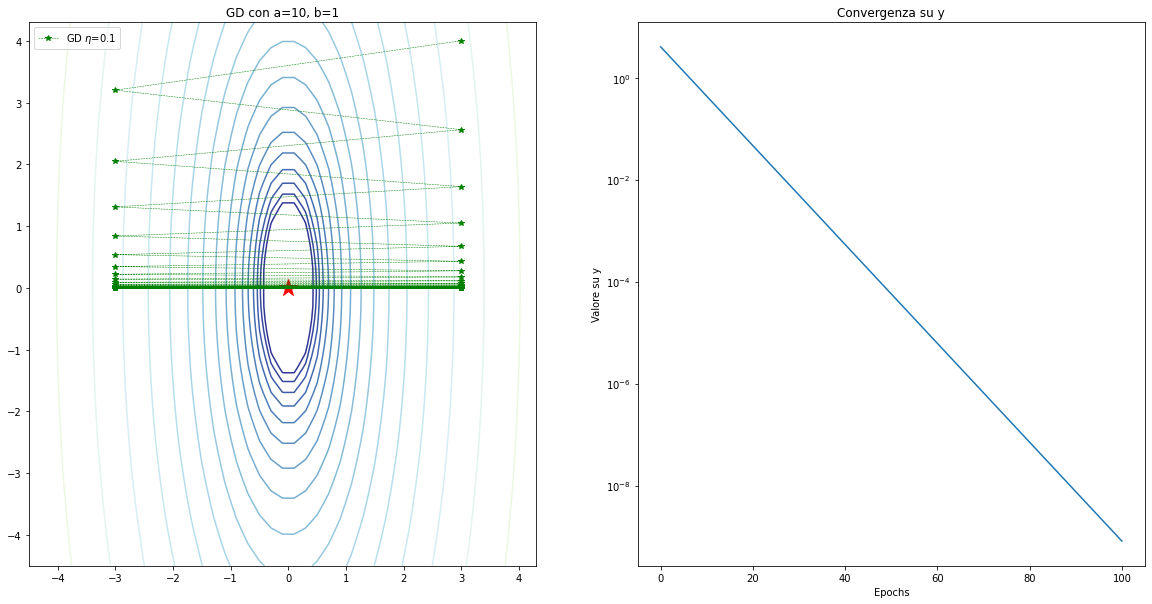

In [0]:
#plottiamo le curve di livello
plt.close()
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
ax = axs[0]

a, b = 10, 1
z = np.abs(minima_surface(x, y, a, b))
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0, 0, 'r*', markersize=18)

#creiamo una funzione che restituisca la funzione gradiente, fissati a e b
def get_grad(a, b):
    def f(params):
        x = params[0]
        y = params[1]
        grad_x = 2 * a * x
        grad_y = 2 * b * y
        return [grad_x, grad_y]
    return f

init = [3, 4] #per migliore resa grafica
ptj = run_and_plot(ax, get_grad(a, b), init,   {'eta': 0.1}, 'g--*')
ax.legend(loc=2)
ax.set(title = "GD con a=10, b=1")

ax1 = axs[1]
ax1.semilogy()
traj_y = np.asarray(ptj)[:, 1]
ax1.plot(traj_y) #andamento convergenza al minimo
ax1.set(ylabel="Valore su y", xlabel = "Epochs", title="Convergenza su y") 

plt.show()

Nei casi non patologici, a differenza del caso simmetrico, la discesa non avviene lungo il raggio che va dal punto iniziale verso l'origine, ma lungo una traiettoria curva non oscillante, come si vede in figura, con $\eta = 0.09, a=3, b=1$.
Ciò avviene quando $a \cdot \eta < 0.5$.
Nei casi $0.5 < a \cdot \eta < 1$ la traiettoria, seppur convergente, presenta oscillazioni, come si vede in figura.

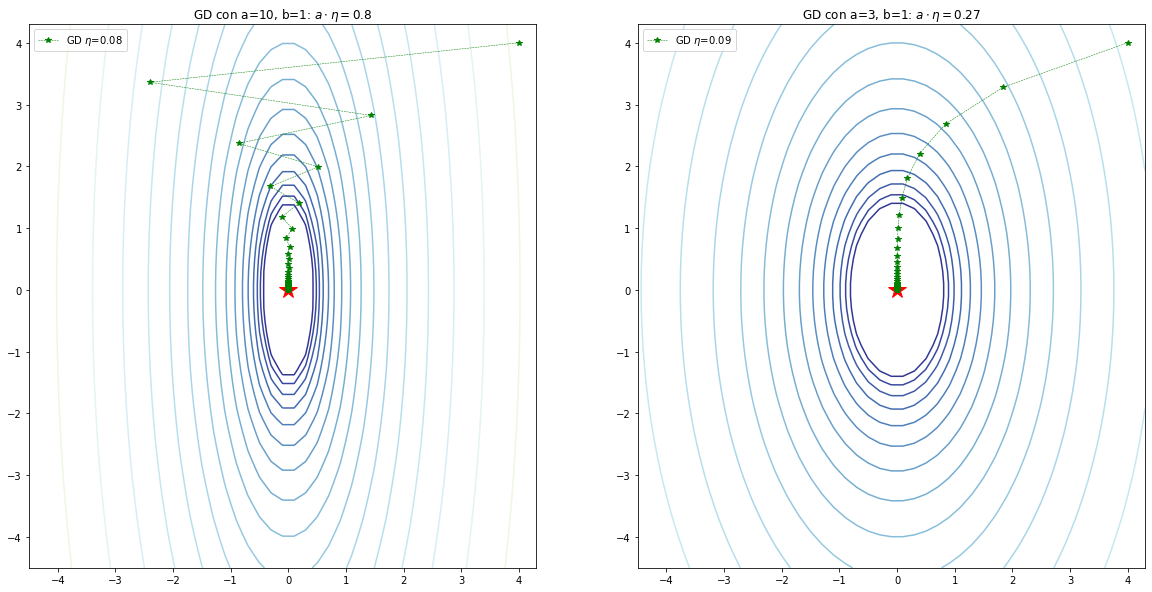

In [0]:
init = [4, 4]
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

pars = [
    {"a": 10, "b": 1, "e": 0.08},
    {"a": 3, "b": 1, "e": 0.09},
]

for i in range(2):
    par = pars[i]
    a, b, eta = par["a"], par["b"], par["e"]
    z = np.abs(minima_surface(x, y, a, b))
    axs[i].contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
    axs[i].plot(0, 0, 'r*', markersize=18)
    ptj = run_and_plot(axs[i], get_grad(a, b), init, {'eta': eta}, 'g--*')
    axs[i].legend(loc=2)
    axs[i].set(title=f"GD con a={a}, b={b}: $a\cdot \eta = {a*eta}$")
    
plt.show()

#### Osserviamo ora cosa accade utilizzando la discesa del gradiente con Momentum. <br>
Eseguiamo l'algoritmo nei casi patologici, per evidenziare le differenze col caso precedente. <br>
Adottando come parametri $a=10,\,b=1$ ed $\eta=0.1$ osserviamo che a differenza del caso precedente
si giunge a convergenza su entrambi gli assi; tuttavia la discesa lungo l'asse y non avviene in maniera esponenziale
ma con un andamento tipico degli oscillatori smorzati. <br>
Si converge nella stessa maniera su x, ma con frequenza molto maggiore.  <br>
Pensiamo che sia imputabile al fatto che il gradiente lungo tale direzione è maggiore in modulo.


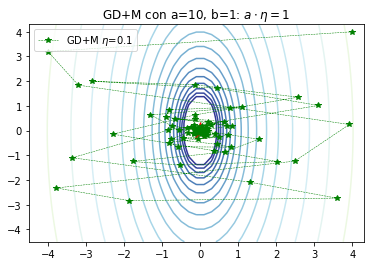

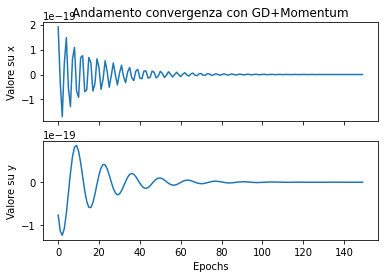

            x             y
 4.303750e-23  4.303750e-23
-1.085987e-22 -1.085987e-22
-2.787388e-23 -2.787388e-23
 1.005262e-22  1.005262e-22
 1.503387e-23  1.503387e-23
-9.197697e-23 -9.197697e-23
-4.332785e-24 -4.332785e-24
 8.321255e-23  8.321255e-23
-4.421749e-24 -4.421749e-24
-7.444912e-23 -7.444912e-23


In [0]:
a, b, eta = 10, 1, 0.1

z = np.abs(minima_surface(x, y, a, b))
plt.contour(x, y, z, levels=np.logspace(0.0, 5, 35), norm=LogNorm(), cmap="RdYlBu_r")
plt.plot(0, 0, 'r*', markersize=18)

ptj = run_and_plot(plt, get_grad(a, b), init, {'eta': eta}, 'g--*', opt=gd_with_mom, n_epochs=1000)

plt.legend(loc=2)
plt.title("GD+M con a=10, b=1: $a\cdot \eta = 1 $")
plt.show()
plt.close()

traj_x, traj_y = np.asarray(ptj)[:, 0], np.asarray(ptj)[:, 1]
fig, axs = plt.subplots(2, sharex=True)
axs[0].plot(traj_x[-150:])
axs[0].set(ylabel='Valore su x',title='Andamento convergenza con GD+Momentum')
axs[1].plot(traj_y[-150:])
axs[1].set(xlabel='Epochs',ylabel='Valore su y')
plt.show()
#stampiamo la tabella con le traiettoria delle ultime 10 epoche,
#in modo da verificare l'effettiva convergenza.
print(pd.DataFrame({
    "x": traj_x[-10:],
    "y": traj_x[-10:]}
).to_string(index=False))

## Tecniche GD con uso di learning rate adattivi: RMSProp e ADAM

Il learning rate è fissato dalla direzione più ripida del landscape della funzione da minimizzare, ma questa può cambiare a seconda del punto locale in cui ci troviamo. <br>
Per aggirare questo problema, idealmente dovremmo scegliere di dare grandi step nelle direzioni che corrispondono a zone piatte del landscape energetico e piccoli passi in direzioni ripide e strette. <br>
I cosidetti metodi del secondo ordine ottengono questo risultato calcolando o approssimando l'Hessiano e normalizzando il learning rate con la curvatura delal superficie nell'intorno del punto in cui ci si trova.  <br>
Questi metodi tuttavia sono molto costosti dal punto di vista computazionale specie per modelli con un grande numero di parametri e quindi in pratica non sono applicabili. <br>
Sono stati quindi introdotti numerosi metodi che consentono in modo computazionalemnte efficiente di adattare il learning rate seguendo il gradiente ed il momento secondo del gradiente stesso. <br>
Metodi di questo tipo includono AdaGrad, AdaDelta, RMSProp e ADAM.

* Esempio: RMSProp (Root-Mean-Square propagation)

durante le iterazioni oltre a tenere in memoria il momento primo del gradiente attraverso una media mobile (running average), viene anche tenuta memoria del momento secondo. La regola di aggiornamento è data da:

$$
\mathbf{g}_t = \nabla_w E(\boldsymbol{w}) \\
\mathbf{s}_t =\beta \mathbf{s}_{t-1} +(1-\beta)\mathbf{g}_t^2 \nonumber \\
\boldsymbol{w}_{t+1}=\boldsymbol{w}_t + \eta_t { \mathbf{g}_t \over \sqrt{\mathbf{s}_t +\epsilon}}, \nonumber \\
$$

con $\beta$ parametro che controlla il tempo di media del momento secondo (tipicamente $\beta\sim 0.9$), e
$\eta_t$ learning rate (tipicamente $\sim 10^{-3}$ e $\epsilon\sim 10^{-8}$ una piccola costante che serve ad evitare divergenze.

Si vede come il learning rate è ridotto nelle direzioni in cui la norma del gradiente è costantemente ampia. Ciò accelera notevolmente la convergenza consentendoci di utilizzare un tasso di apprendimento più ampio per direzioni piatte.

* Esempio: ADAM (Adaptive Moment Estimation)

Corregge le stime del primo e secondo momento per il bias dovuto al fatto che sono stime fatte con medie mobili:

$$
\mathbf{g}_t = \nabla_w E(\boldsymbol{w}) \\
\mathbf{m}_t = \beta_1 \mathbf{m}_{t-1} + (1-\beta_1) \mathbf{g}_t \nonumber \\
\mathbf{s}_t =\beta_2 \mathbf{s}_{t-1} +(1-\beta_2)\mathbf{g}_t^2 \nonumber \\
\hat{\mathbf{m}}_t={\mathbf{m}_t \over 1-\beta_1} \nonumber \\
\hat{\mathbf{s}}_t ={\mathbf{s}_t \over1-\beta_2} \nonumber \\
\boldsymbol{w}_{t+1}=\boldsymbol{w}_t + \eta_t { \hat{\mathbf{m}}_t \over \sqrt{\hat{\mathbf{s}}_t +\epsilon}}, \nonumber
$$

con $\beta_1$ e $\beta_2$ che fissano le vite-medie del primo e secondo momento e sono tipicamente $0.9$ e $0.99$ rispettivamente. $\eta$ e $\epsilon$ sono gli stessi di RMSProp.

In [0]:
# Implementazione RMSProp e ADAM
def rms_prop(grad, init, hyper_par, n_epochs=5000, noise_strength=0):
    default_par = OrD([
        ("eta", 10 ** -3),
        ("beta", 0.9),
        ("epsilon", 10 ** -8)
        ])
    eta, beta, epsilon = get_par(hyper_par, default_par)
    params = np.array(init)
    param_traj = np.zeros([n_epochs + 1, 2])
    param_traj[0,] = init
    grad_sq = 0
    for j in range(n_epochs):
        noise = noise_strength * np.random.randn(params.size)
        g = np.array(grad(params)) + noise
        grad_sq = beta * grad_sq + (1 - beta) * g * g
        v = eta * np.divide(g, np.sqrt(grad_sq + epsilon))
        params = params - v
        param_traj[j + 1,] = params

    legend = "RMSprop " + ", ".join(f"$\\{key}$={hyper_par[key]}" for key in hyper_par)
    return (param_traj, legend)


def adams(grad, init, hyper_par, n_epochs=5000, noise_strength=0):
    default_par = OrD([
            ("eta", 10 ** -3),
            ("gamma", 0.9),
            ("beta", 0.99),
            ("epsilon", 10 ** -8),
    ])
    eta, gamma, beta, epsilon = get_par(hyper_par, default_par)

    params = np.array(init)
    param_traj = np.zeros([n_epochs + 1, 2])
    param_traj[0,] = init
    v = 0
    grad_sq = 0
    for j in range(n_epochs):
        noise = noise_strength * np.random.randn(params.size)
        g = np.array(grad(params)) + noise
        v = gamma * v + (1 - gamma) * g
        grad_sq = beta * grad_sq + (1 - beta) * g * g
        v_hat = v / (1 - gamma)
        grad_sq_hat = grad_sq / (1 - beta)
        params = params - eta * np.divide(v_hat, np.sqrt(grad_sq_hat + epsilon))
        param_traj[j + 1,] = params
    legend = "ADAM " + ", ".join(f"$\\{key}$={hyper_par[key]}" for key in hyper_par)
    return (param_traj, legend)

## Applicazione di RMSProp e ADAM


Applichiamo quanto visto alla funzione di Beale:

$$
z = f(x,y) = (1.5-x+xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2.
$$

con minimo globale in $(x,y)=(3,0.5)$.

**Cose si vuole testare:**

* trovare il minimo con: GD, GD+momentum, RMSProp, ADAM, partendo da condizioni iniziali diverse
* analizzare come cambiano le cose cambiando $\eta$ e il numero di iterazioni
* analizzare cosa si ottiene usando $N_{\mathrm{steps}}=10^4$ e $\eta=10^{-3}$ per ADAM/RMSProp e $\eta=10^{-6}$ per GD e GD+momentum

**Da fare come esercizio:**

* cosa succede usando $\eta=10^{-6}$ anche per ADAM/RMSProp
* cosa succede inserendo del rumore nel gioco (ad esempio noise=10)?
* giocate con i parametri degli algoritmi ADAM e RMSProp, cosa cambia?

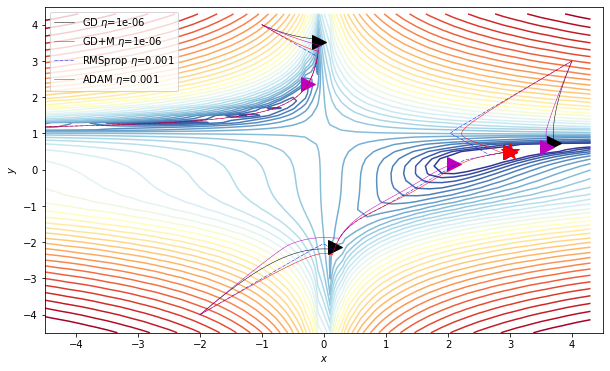

In [0]:
plt.close()

N1=10**4
lr_l=10**-3
lr_s=10**-6

init1 = [4, 3]
fig1, ax1 = contour_beales_function()

grad = grad_beales_function

run_and_plot(ax1, grad, init1, {'eta': lr_s}, 'k', N1, gd, True)
run_and_plot(ax1, grad, init1, {'eta': lr_s}, 'm', N1, gd_with_mom, True)
run_and_plot(ax1, grad, init1, {'eta': lr_l}, 'b-.', N1, rms_prop, True)
run_and_plot(ax1, grad, init1, {'eta': lr_l}, 'r', N1, adams, True)

plt.legend(loc=2)

init2 = [-1,4]

N2=10**5
run_and_plot(ax1, grad, init2, {'eta': lr_s}, 'k', N2, gd, True)
run_and_plot(ax1, grad, init2, {'eta': lr_s}, 'm', N2, gd_with_mom, True)
run_and_plot(ax1, grad, init2, {'eta': lr_l}, 'b-.', N2, rms_prop, True)
run_and_plot(ax1, grad, init2, {'eta': lr_l}, 'r', N2, adams, True)
 
init3 = [-2,-4]

run_and_plot(ax1, grad, init3, {'eta': lr_s}, 'k', N2, gd, True)
run_and_plot(ax1, grad, init3, {'eta': lr_s}, 'm', N2, gd_with_mom, True)
run_and_plot(ax1, grad, init3, {'eta': lr_l}, 'b-.', N2, rms_prop, True)
run_and_plot(ax1, grad, init3, {'eta': lr_l}, 'r', N2, adams, True)

plt.show()

## Svolgimento dell'esercizio
### Learning rate 'piccolo'
Analizziamo il caso in cui $\eta=10^{-6}$. Con numero di epoche pari a $10^5$ si osserva un movimento minuscolo dal punto di partenza (ordine $10^{-2}$). Viene quindi eseguito quindi l'algoritmo con un numero di epoche pari a $10^6$.
Scegliamo punti di partenza poco distanti osserviamo che gli algoritmo percorrono tragitti simili.
La scelta poco conveniente di un learning rate basso comporta l'impossibilità da parte dell'algoritmo di arrivare a convergenza.
Il tempo d'esecuzione (su Colab) è di 2 minuti.

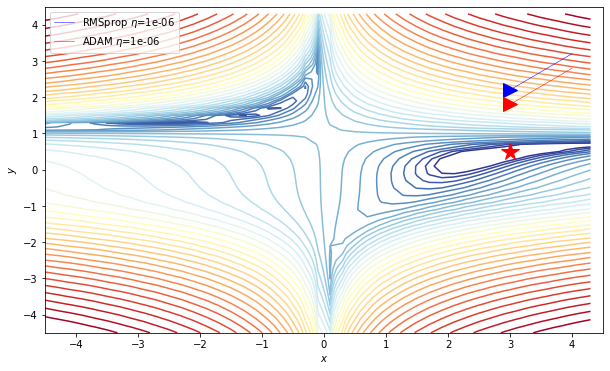

In [0]:
plt.close()

N1, lr_s = 10**6, 10**-6

fig1, ax = contour_beales_function()

grad = grad_beales_function

run_and_plot(ax, grad, [4, 3.2], {'eta': lr_s}, 'b', N1, rms_prop, True)
run_and_plot(ax, grad, [4, 2.8], {'eta': lr_s}, 'r', N1, adams, True)

plt.legend(loc=2)
plt.show()

## Inserimento rumore
Verifichiamo l'andamento in presenza di rumore confrontandolo con quello in assenza di rumore.
Nella parte iniziale della discesa questo la ritarda ma non in maniera drastica invece
 inoltre una volta giunto in prossimità del minimo, l'algoritmo
non riesce a stabilizzarsi e il rumore diventa preponderante.


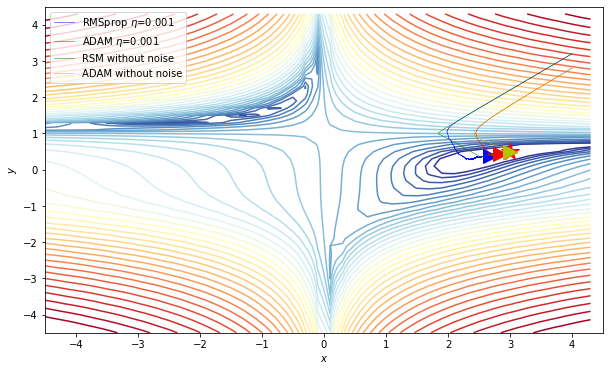

In [0]:
plt.close()
N1 = 10**4
lr_s = 10**-3

grad = grad_beales_function

rms_t = run_and_plot(ax1, grad, [4, 3.2], {'eta': lr_s}, 'b', N1, rms_prop, True)
adam_t = run_and_plot(ax1, grad, [4, 2.8], {'eta': lr_s}, 'r', N1, adams, True)
plt.close()
fig1, ax1=contour_beales_function()
#run_and_plot(ax, gradient, init, hyper_par, marker='o', n_epochs=100, opt=gd, arrow=False, noise=0):
rms_n = run_and_plot(ax1, grad, [4, 3.2], {'eta': lr_s}, 'b', N1, rms_prop, True, noise=10)
adam_n = run_and_plot(ax1, grad, [4, 2.8], {'eta': lr_s}, 'r', N1, adams, True, noise=10)
overlay_trajectory_contour_M(ax1, rms_t, "RSM without noise", 'g', lw=0.5)
overlay_trajectory_contour_M(ax1, adam_t, "ADAM without noise", 'y', lw=0.5)
plt.legend(loc=2)
plt.show()


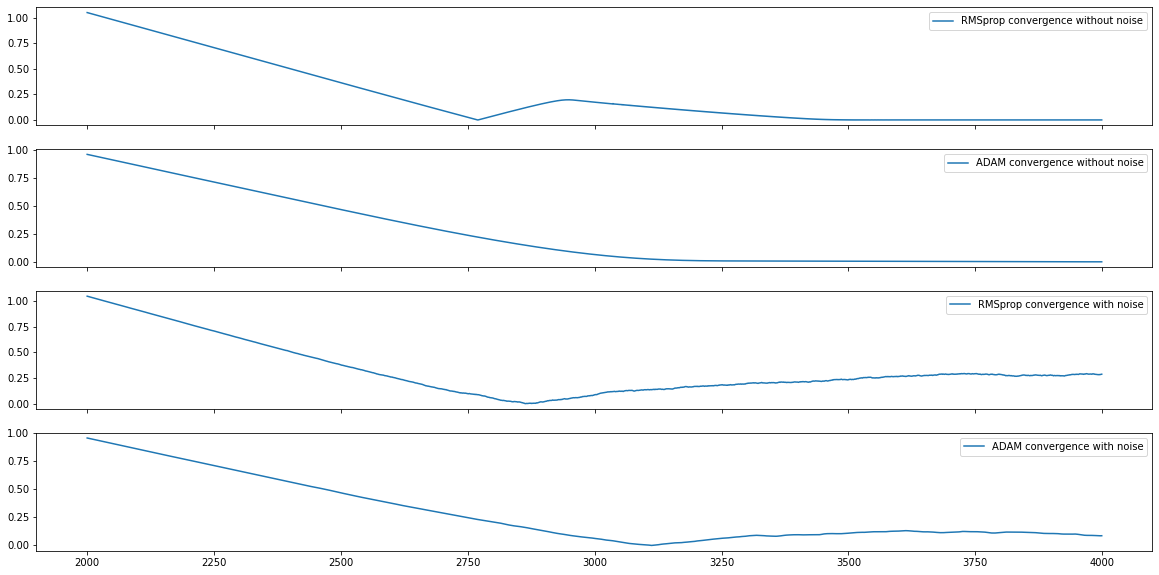

In [0]:
plt.close()
fig, axs = plt.subplots(4, sharex=True, figsize=(20, 10))
fp = np.array([3, 0.5])

def plot_learn(ax, traj, final_point, label="",  epochs=None,):
    #plottiamo l'andamento della distanza dal minimo
    if epochs is not None:
        ax.plot(epochs, np.sqrt((traj[:] - final_point)[:, 1]**2 + (traj[:] - final_point)[:, 1]**2), label=label)
    else:
        ax.plot(np.sqrt((traj[:] - final_point)[:, 1]**2 + (traj[:] - final_point)[:, 1]**2), label=label)
    ax.legend(loc=1)

#mostriamo solo l'andamento intorno al minimo, che riteniamo più significativa
#l'andamento nella parte precedente è sostanzialmente lineare
epochs = np.arange(2000, 4000, 1)
plot_learn(axs[0], rms_t[epochs], fp, label="RMSprop convergence without noise", epochs=epochs)
plot_learn(axs[1], adam_t[epochs], fp, label="ADAM convergence without noise", epochs=epochs)
plot_learn(axs[2], rms_n[epochs], fp, label="RMSprop convergence with noise", epochs=epochs)
plot_learn(axs[3], adam_n[epochs], fp, label="ADAM convergence with noise", epochs=epochs)

plt.show()


#### Esploriamo gli scenari che si propongono per i diversi valori dei parametri degli algoritmi. ####
 ### RMSProp
 Valutiamo le prestazioni dell'algoritmo per 10 valori di $\beta$ equidistanziati
tra 0.96 a 0.99 con un rumore pari a 10. <br>
 Da un'analisi preliminare abbiamo osservato che si presenta lo stesso andamento
variando in maniera drastica tale parametro, fino a $0.97$ circa. <br>
 Si osserva che fintanto che $\beta$ è minore di 0.97 si impiega lo stesso numero di epoche
per giungere a convergenza mentre per valori superiore a 0.99 si passa da 2500 epoche a più di 3000 per raggiungere la convergenza. Si ha poi il caso $\beta$ = 0.999 in cui la convergenza non è raggiunta dopo 5000 epoche. <br>
Nei grafici in figura c'è il numero di epoche sulle ascisse e la distanza dal punto di minimo sulle ordinate.

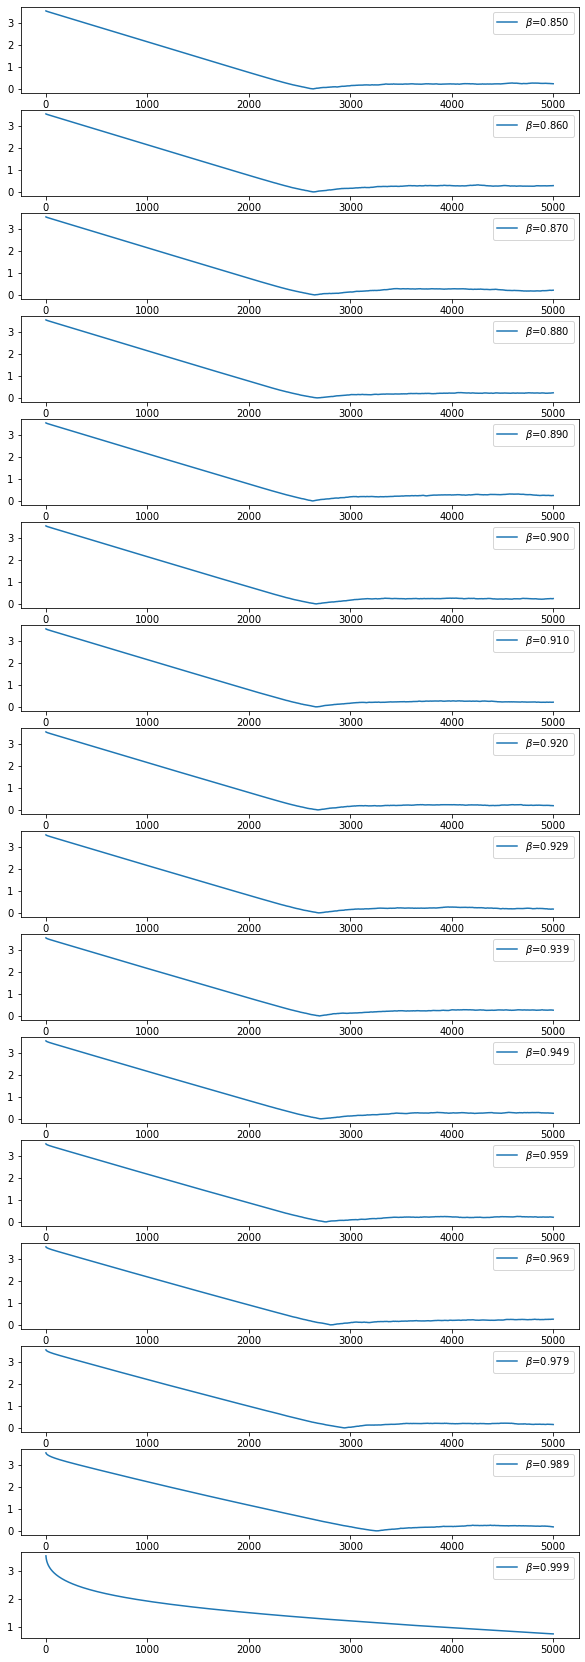

In [0]:
plt.close()
beta_n = 16
fig, axs = plt.subplots(beta_n, figsize=(10,30))
betas = np.linspace(0.850, 0.999, beta_n)
for i in range(beta_n):
    traj, legend = rms_prop(grad, [4, 3], {'beta': betas[i]}, n_epochs=5000, noise_strength=10)
    plot_learn(axs[i], traj[:], fp, label='$\\beta$=%.3f' % betas[i])
    axs[i].legend(loc=1)
plt.show()

##Adam 
### variazione del parametro $\beta$
Variamo il parametro $\beta$ anche in Adam, mantenendo $\gamma$ costante. <br>
A differenza del caso di RMSProp, si vede una differenza maggiore nei tempi di convergenza variandio anche di poco il parametro studiato. Si nota infatti che partendo da una convergenza in circa 600 epoche con $\beta$ = 0.899 l'incremento è molto piccolo per valori inferiori a 0.920 e aumenta significativamente per valori superiori, arrivando a circa 1000 epoche per $\beta$ = 0.929 fino alle 3000 epoche con $\beta$ = 0.989.
Come prima, il caso limite di $\beta$ prossima a uno ($\beta$ = 0.999) rallenta la convergenza, avvicinandosi lentamente ad essa e, nelle epoche da noi studiate, non raggiungendola.



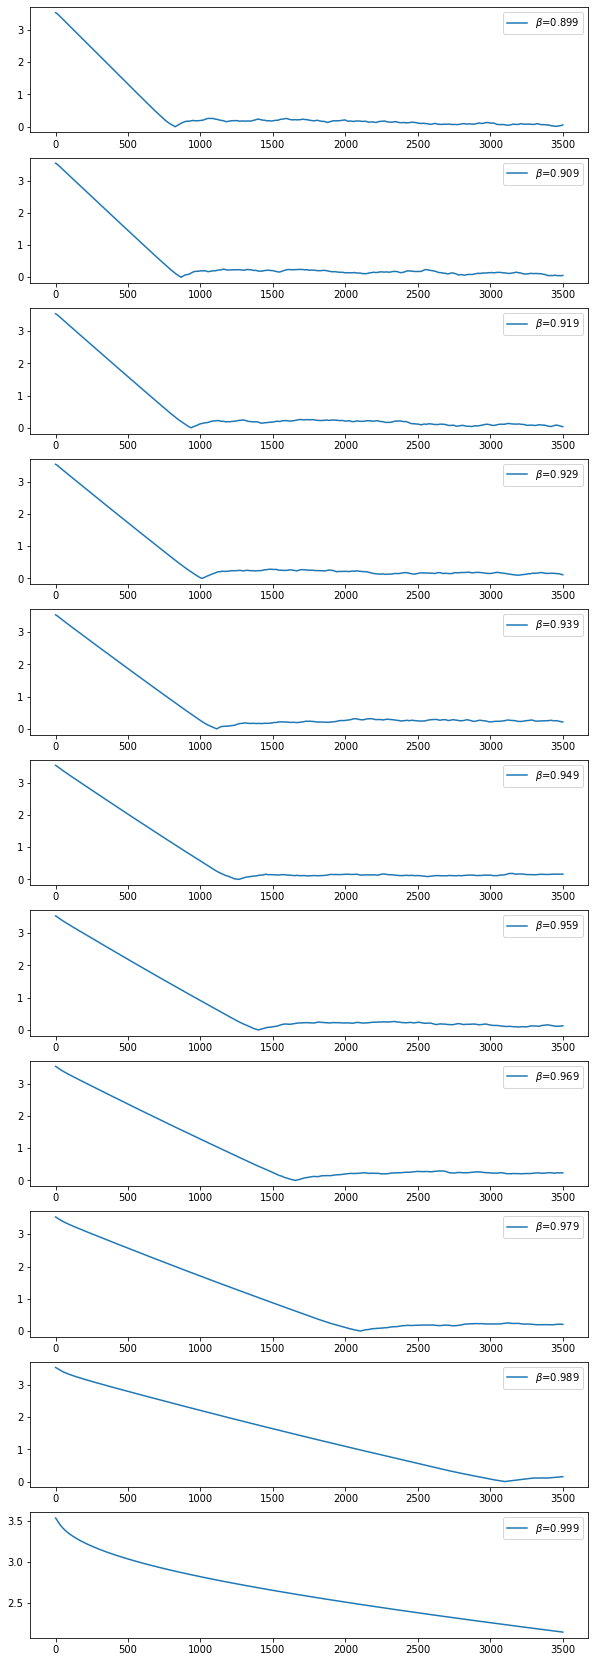

In [0]:
plt.close()
beta_n = 11
fig, axs = plt.subplots(beta_n, figsize=(10,30))
betas = np.linspace(0.899, 0.999, beta_n)
for i in range(beta_n):
    traj, legend = adams(grad, [4, 3], {'beta': betas[i]}, n_epochs=3500, noise_strength=10)
    plot_learn(axs[i], traj[:], fp, label='$\\beta$=%.3f' % betas[i])
    axs[i].legend(loc=1)
plt.show()

##Adam
###Variazione del parametro $\gamma$
Qui modifichiamo invece il parametro $\gamma$ mantenendo $\beta$ costante.
il paramentro utilizzato di default per gamma è 0.90, scegliamo dunque di farlo variare in un range [0.850 , 0,950]. <br>
Contrariamente a quanto aspettato, si ha una convergenza più veloce per $\gamma$ = 0.950, con la velocità di convergenza che diminuisce mano a mano che $\gamma$ aumenta.

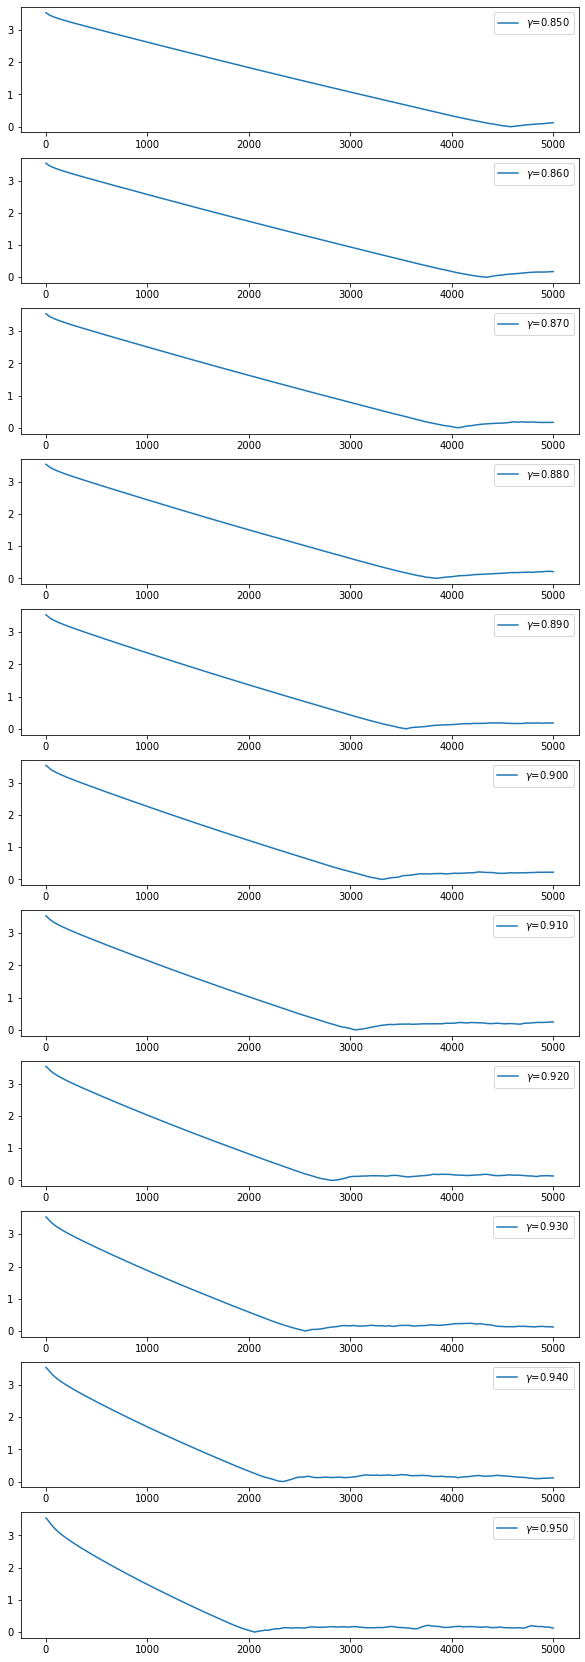

In [0]:
plt.close()
gamma_n = 11
fig, axs = plt.subplots(gamma_n, figsize=(10,30))
gammas = np.linspace(0.850, 0.950, gamma_n)
for i in range(gamma_n):
    traj, legend = adams(grad, [4, 3], {'gamma': gammas[i]}, n_epochs=5000, noise_strength=10)
    plot_learn(axs[i], traj[:], fp, label='$\\gamma$=%.3f' % gammas[i])
    axs[i].legend(loc=1)
plt.show()

##Adam
###Variazione di $\beta$ e $\gamma$
Proviamo ora a far variare sia $\beta$ che $\gamma$ contemporaneamente, usando gli stessi intervalli precedenti. <br>
Come prima sul caso limite di $\beta$ = 0.999 non si ha convergenza nelle epoche da noi studiate. <br>
Si riscontra come in precedenza che all'aumentare di $\gamma$ nell'intervallo scelto la convergenza si velocizza; per quanto riguarda $\beta$ avviene il contrario: la convergenza migliore si ha per $\beta$ = 0.899. Si vede quindi che il tempo di convergenza minore di ha per ( $\beta$ , $\gamma$ ) = ( 0.899 , 0.950 ). <br>



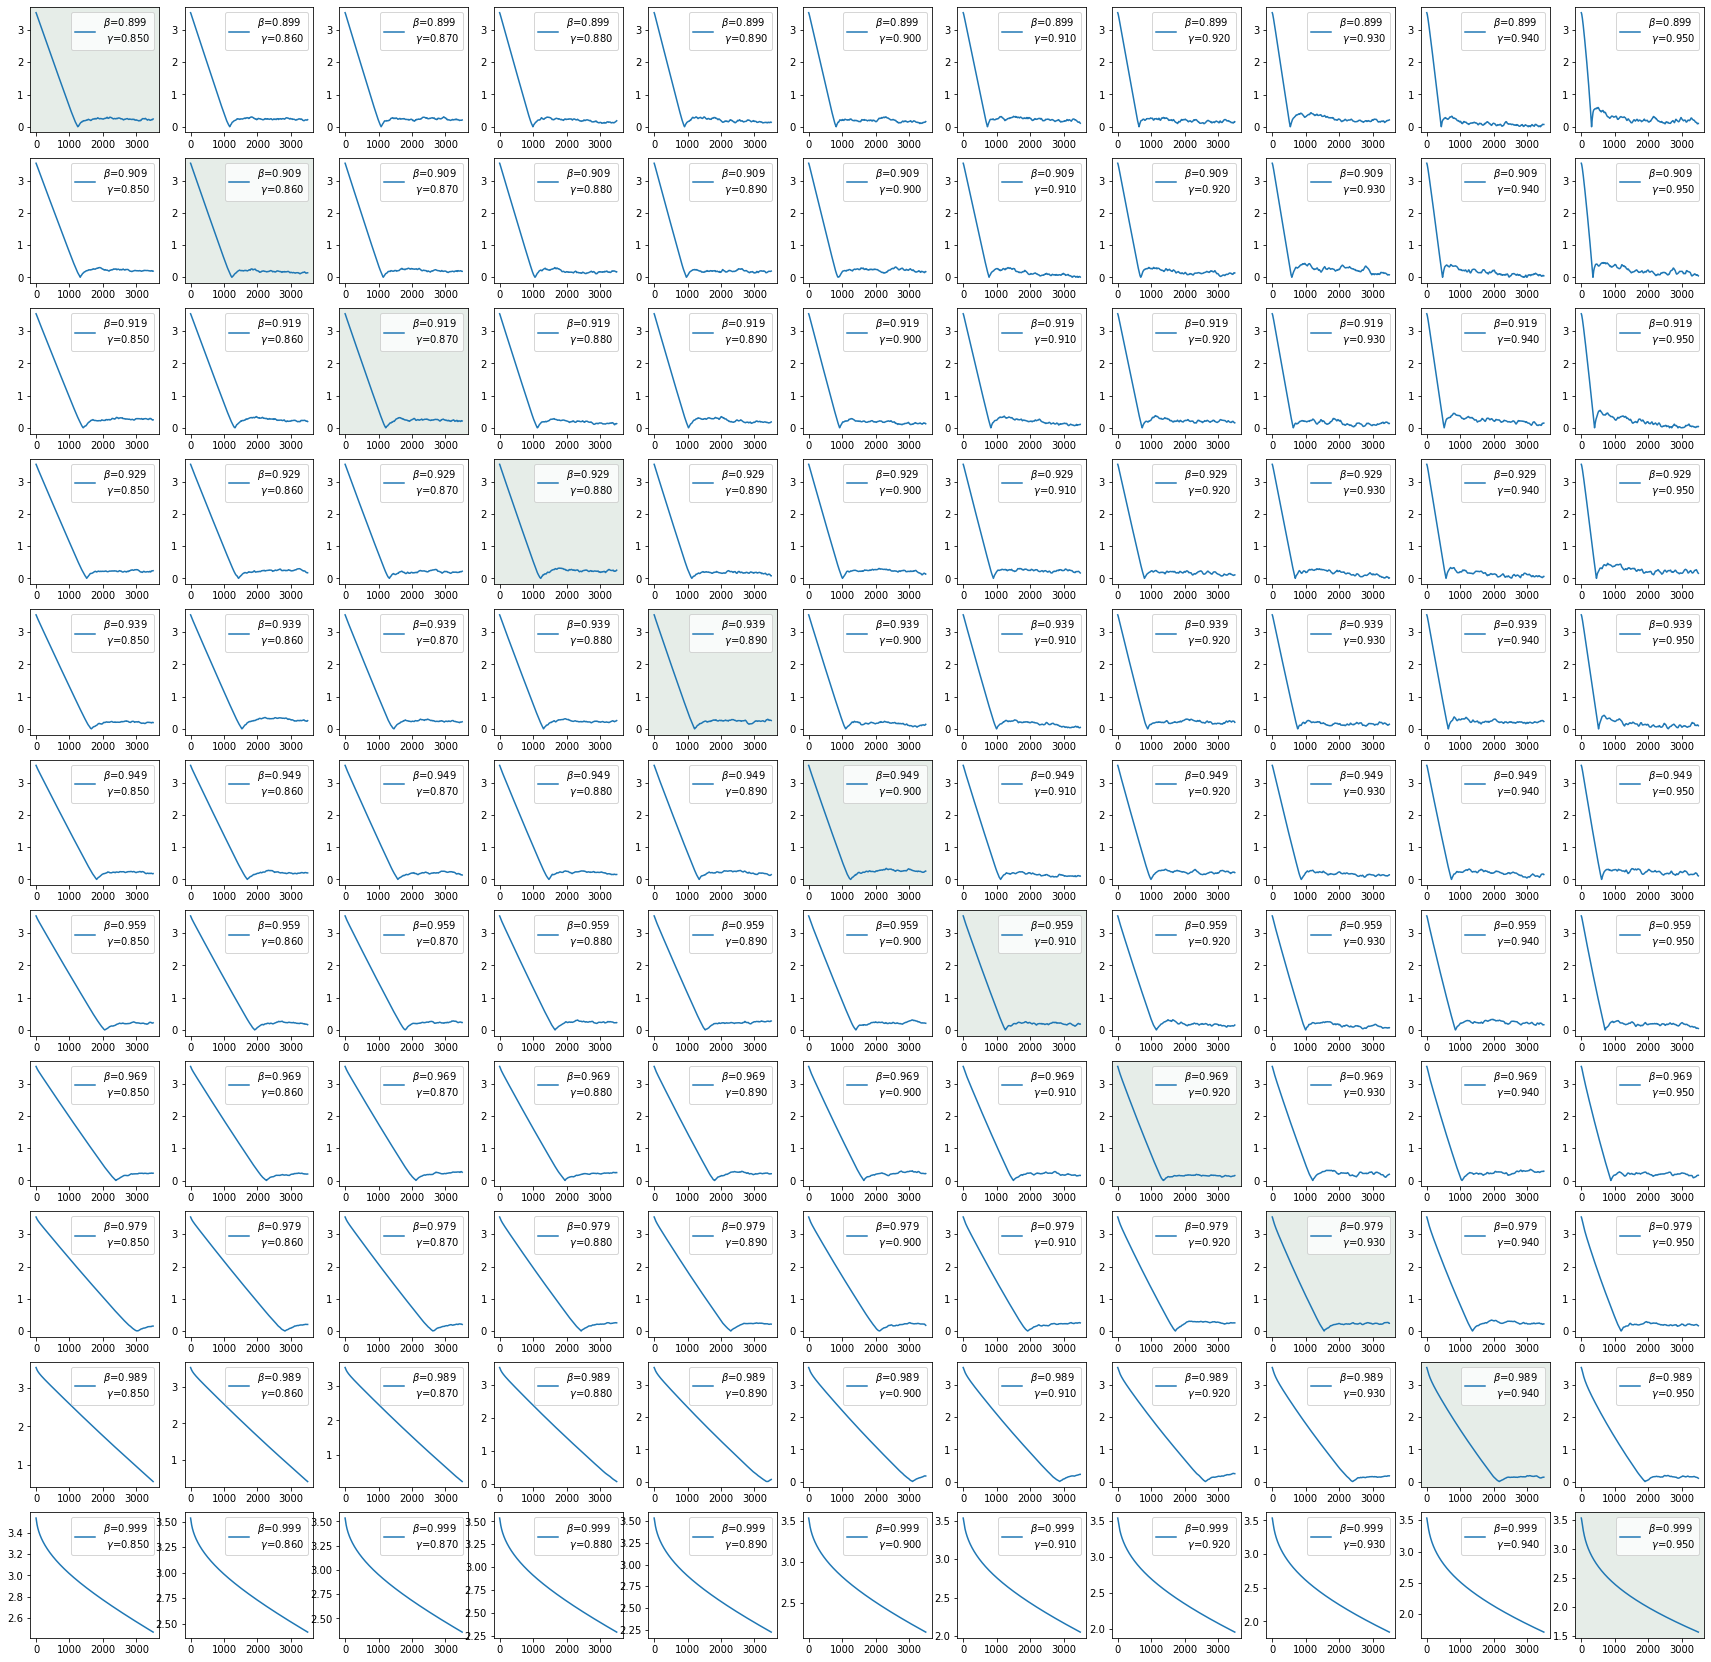

In [0]:
plt.close()
gamma_n = 11
beta_n = 11
gammas = np.linspace(0.850, 0.950, gamma_n)
betas = np.linspace(0.899, 0.999, beta_n)
fig, axs = plt.subplots(beta_n, gamma_n, figsize=(30,30))
for i in range(beta_n):
  for j in range (gamma_n):
    traj, legend = adams(grad, [4, 3], {'gamma':gammas[j], 'beta': betas[i]}, n_epochs=3500, noise_strength=10)
    plot_learn(axs[i][j], traj[:], fp, label='$\\beta$=%.3f \n $\\gamma$=%.3f' % (betas[i], gammas[j]))
    axs[i][j].legend(loc=1)
    axs[i][i].set_facecolor('#e6ede8')
  
plt.show()
